In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

# Preprocessing and Data Augmentation

In [4]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='100Hz', window=False,denoize=False, addGaussianNoise=True, reduceChannels=False, cutEnd=False)
preprocessed_input_test, preprocessed_input_test_target=preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='100Hz', window=False,denoize=False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (3000, 28, 50)
test (1000, 28, 50)
validation (160, 28, 50)
Ntrain =  3000
Ntest =  1000
Nvalidation =  160


# Network training and testing

In [5]:
import torch.optim as optim
import math

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 7
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 50
seeds = list(range(10))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):
    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    #model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from PdM
    #model = conv2DNet_4(Noutputs) #from PdM
    #model = conv2DNet_5(Noutputs)
    #model = conv2DNet_6(Noutputs)
    #model = conv2DNet_7(Noutputs)
    model = conv2DNet_9(Noutputs)
    
    #optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model.forward(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output.view(bsize_eff), train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size, criterion)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size, criterion)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size, criterion)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
Epoch Number :  0
	 Training accuracy:  68.36666666666666
	 Validation accuracy  60.625
	 Test accuracy  53.6
	 Epoch Loss  291.9435119628906
Epoch Number :  1
	 Training accuracy:  76.93333333333334
	 Validation accuracy  70.0
	 Test accuracy  74.9
	 Epoch Loss  267.5791320800781
Epoch Number :  2
	 Training accuracy:  79.0
	 Validation accuracy  69.375
	 Test accuracy  71.5
	 Epoch Loss  245.3934783935547
Epoch Number :  3
	 Training accuracy:  78.46666666666667
	 Validation accuracy  75.0
	 Test accuracy  74.6
	 Epoch Loss  238.1402130126953
Epoch Number :  4
	 Training accuracy:  80.0
	 Validation accuracy  73.75
	 Test accuracy  78.3
	 Epoch Loss  234.5059051513672
Epoch Number :  5
	 Training accuracy:  78.36666666666666
	 Validation accuracy  87.5
	 Test accuracy  74.4
	 Epoch Loss  232.3300323486328
Epoch Number :  6
	 Training accuracy:  78.73333333333333
	 Validation accuracy  70.0
	 Test accuracy  78.3
	 Epoch Loss  226.4195098876953
Epoch Number :  7
	 Training

Epoch Number :  9
	 Training accuracy:  81.8
	 Validation accuracy  74.375
	 Test accuracy  79.3
	 Epoch Loss  208.43472290039062
Epoch Number :  10
	 Training accuracy:  79.03333333333333
	 Validation accuracy  68.75
	 Test accuracy  76.6
	 Epoch Loss  210.89659118652344
Epoch Number :  11
	 Training accuracy:  78.7
	 Validation accuracy  69.375
	 Test accuracy  75.9
	 Epoch Loss  200.908447265625
Epoch Number :  12
	 Training accuracy:  79.46666666666667
	 Validation accuracy  75.0
	 Test accuracy  74.7
	 Epoch Loss  202.94232177734375
Epoch Number :  13
	 Training accuracy:  82.2
	 Validation accuracy  69.375
	 Test accuracy  77.0
	 Epoch Loss  202.0353240966797
Epoch Number :  14
	 Training accuracy:  80.8
	 Validation accuracy  70.0
	 Test accuracy  78.8
	 Epoch Loss  199.41912841796875
Epoch Number :  15
	 Training accuracy:  83.66666666666667
	 Validation accuracy  72.5
	 Test accuracy  75.6
	 Epoch Loss  193.0110626220703
Epoch Number :  16
	 Training accuracy:  83.333333333333

Epoch Number :  19
	 Training accuracy:  85.13333333333334
	 Validation accuracy  70.625
	 Test accuracy  70.2
	 Epoch Loss  186.65872192382812
Epoch Number :  20
	 Training accuracy:  84.56666666666666
	 Validation accuracy  74.375
	 Test accuracy  69.4
	 Epoch Loss  183.154296875
Epoch Number :  21
	 Training accuracy:  84.43333333333334
	 Validation accuracy  76.25
	 Test accuracy  74.2
	 Epoch Loss  189.1718292236328
Epoch Number :  22
	 Training accuracy:  85.66666666666667
	 Validation accuracy  73.75
	 Test accuracy  70.8
	 Epoch Loss  185.40370178222656
Epoch Number :  23
	 Training accuracy:  84.16666666666667
	 Validation accuracy  75.0
	 Test accuracy  68.9
	 Epoch Loss  181.06045532226562
Epoch Number :  24
	 Training accuracy:  85.06666666666666
	 Validation accuracy  72.5
	 Test accuracy  68.3
	 Epoch Loss  178.9901123046875
Epoch Number :  25
	 Training accuracy:  85.36666666666666
	 Validation accuracy  71.25
	 Test accuracy  68.5
	 Epoch Loss  181.24143981933594
Epoch 

Epoch Number :  28
	 Training accuracy:  83.13333333333334
	 Validation accuracy  61.875
	 Test accuracy  71.1
	 Epoch Loss  174.85340881347656
Epoch Number :  29
	 Training accuracy:  84.06666666666666
	 Validation accuracy  69.375
	 Test accuracy  72.8
	 Epoch Loss  181.05667114257812
Epoch Number :  30
	 Training accuracy:  80.36666666666666
	 Validation accuracy  64.375
	 Test accuracy  72.3
	 Epoch Loss  173.76280212402344
Epoch Number :  31
	 Training accuracy:  86.0
	 Validation accuracy  68.75
	 Test accuracy  69.0
	 Epoch Loss  174.14785766601562
Epoch Number :  32
	 Training accuracy:  85.4
	 Validation accuracy  68.75
	 Test accuracy  66.0
	 Epoch Loss  183.62545776367188
Epoch Number :  33
	 Training accuracy:  85.13333333333334
	 Validation accuracy  68.125
	 Test accuracy  68.4
	 Epoch Loss  172.89378356933594
Epoch Number :  34
	 Training accuracy:  85.36666666666666
	 Validation accuracy  68.75
	 Test accuracy  70.2
	 Epoch Loss  174.08326721191406
Epoch Number :  35
	 

Epoch Number :  38
	 Training accuracy:  84.16666666666667
	 Validation accuracy  78.125
	 Test accuracy  69.9
	 Epoch Loss  165.31936645507812
Epoch Number :  39
	 Training accuracy:  86.06666666666666
	 Validation accuracy  90.0
	 Test accuracy  68.8
	 Epoch Loss  165.5286102294922
Epoch Number :  40
	 Training accuracy:  82.63333333333334
	 Validation accuracy  73.125
	 Test accuracy  69.2
	 Epoch Loss  163.4213409423828
Epoch Number :  41
	 Training accuracy:  82.43333333333334
	 Validation accuracy  76.25
	 Test accuracy  65.8
	 Epoch Loss  171.2482147216797
Epoch Number :  42
	 Training accuracy:  84.16666666666667
	 Validation accuracy  81.875
	 Test accuracy  68.8
	 Epoch Loss  170.11024475097656
Epoch Number :  43
	 Training accuracy:  84.63333333333334
	 Validation accuracy  82.5
	 Test accuracy  69.2
	 Epoch Loss  165.30813598632812
Epoch Number :  44
	 Training accuracy:  85.26666666666667
	 Validation accuracy  86.875
	 Test accuracy  68.0
	 Epoch Loss  168.8860321044922
E

Epoch Number :  47
	 Training accuracy:  88.0
	 Validation accuracy  85.625
	 Test accuracy  65.2
	 Epoch Loss  157.62496948242188
Epoch Number :  48
	 Training accuracy:  86.7
	 Validation accuracy  80.0
	 Test accuracy  65.3
	 Epoch Loss  160.08749389648438
Epoch Number :  49
	 Training accuracy:  87.63333333333334
	 Validation accuracy  76.25
	 Test accuracy  64.3
	 Epoch Loss  163.91748046875
Repetition 6
Epoch Number :  0
	 Training accuracy:  61.0
	 Validation accuracy  38.125
	 Test accuracy  51.2
	 Epoch Loss  299.4394226074219
Epoch Number :  1
	 Training accuracy:  64.83333333333333
	 Validation accuracy  38.125
	 Test accuracy  52.8
	 Epoch Loss  288.5236511230469
Epoch Number :  2
	 Training accuracy:  69.93333333333334
	 Validation accuracy  34.375
	 Test accuracy  54.4
	 Epoch Loss  279.7313537597656
Epoch Number :  3
	 Training accuracy:  73.23333333333333
	 Validation accuracy  37.5
	 Test accuracy  53.3
	 Epoch Loss  268.6495361328125
Epoch Number :  4
	 Training accur

Epoch Number :  6
	 Training accuracy:  81.7
	 Validation accuracy  64.375
	 Test accuracy  72.6
	 Epoch Loss  223.6203155517578
Epoch Number :  7
	 Training accuracy:  78.33333333333333
	 Validation accuracy  60.0
	 Test accuracy  76.7
	 Epoch Loss  217.70245361328125
Epoch Number :  8
	 Training accuracy:  83.46666666666667
	 Validation accuracy  78.125
	 Test accuracy  71.6
	 Epoch Loss  215.1839141845703
Epoch Number :  9
	 Training accuracy:  80.9
	 Validation accuracy  67.5
	 Test accuracy  73.1
	 Epoch Loss  212.33163452148438
Epoch Number :  10
	 Training accuracy:  83.13333333333334
	 Validation accuracy  66.25
	 Test accuracy  72.0
	 Epoch Loss  209.25546264648438
Epoch Number :  11
	 Training accuracy:  84.03333333333333
	 Validation accuracy  68.75
	 Test accuracy  69.6
	 Epoch Loss  205.02267456054688
Epoch Number :  12
	 Training accuracy:  81.86666666666666
	 Validation accuracy  61.25
	 Test accuracy  75.8
	 Epoch Loss  202.48602294921875
Epoch Number :  13
	 Training a

Epoch Number :  15
	 Training accuracy:  83.63333333333334
	 Validation accuracy  81.875
	 Test accuracy  72.0
	 Epoch Loss  193.03782653808594
Epoch Number :  16
	 Training accuracy:  82.0
	 Validation accuracy  81.875
	 Test accuracy  73.8
	 Epoch Loss  190.04318237304688
Epoch Number :  17
	 Training accuracy:  82.86666666666666
	 Validation accuracy  83.75
	 Test accuracy  73.5
	 Epoch Loss  191.27529907226562
Epoch Number :  18
	 Training accuracy:  85.53333333333333
	 Validation accuracy  81.875
	 Test accuracy  73.2
	 Epoch Loss  186.57534790039062
Epoch Number :  19
	 Training accuracy:  81.6
	 Validation accuracy  79.375
	 Test accuracy  73.7
	 Epoch Loss  183.59329223632812
Epoch Number :  20
	 Training accuracy:  87.06666666666666
	 Validation accuracy  81.25
	 Test accuracy  72.4
	 Epoch Loss  178.17247009277344
Epoch Number :  21
	 Training accuracy:  84.3
	 Validation accuracy  85.625
	 Test accuracy  73.4
	 Epoch Loss  183.39122009277344
Epoch Number :  22
	 Training acc

Epoch Number :  24
	 Training accuracy:  83.23333333333333
	 Validation accuracy  70.625
	 Test accuracy  77.0
	 Epoch Loss  182.71792602539062
Epoch Number :  25
	 Training accuracy:  85.23333333333333
	 Validation accuracy  68.75
	 Test accuracy  76.5
	 Epoch Loss  180.2976531982422
Epoch Number :  26
	 Training accuracy:  86.76666666666667
	 Validation accuracy  66.25
	 Test accuracy  72.1
	 Epoch Loss  183.8433380126953
Epoch Number :  27
	 Training accuracy:  84.73333333333333
	 Validation accuracy  67.5
	 Test accuracy  75.9
	 Epoch Loss  180.3383026123047
Epoch Number :  28
	 Training accuracy:  84.36666666666666
	 Validation accuracy  65.0
	 Test accuracy  76.8
	 Epoch Loss  178.81594848632812
Epoch Number :  29
	 Training accuracy:  82.7
	 Validation accuracy  64.375
	 Test accuracy  76.9
	 Epoch Loss  173.12193298339844
Epoch Number :  30
	 Training accuracy:  84.8
	 Validation accuracy  63.75
	 Test accuracy  74.8
	 Epoch Loss  183.15777587890625
Epoch Number :  31
	 Trainin

torch.Size([10, 50])
0


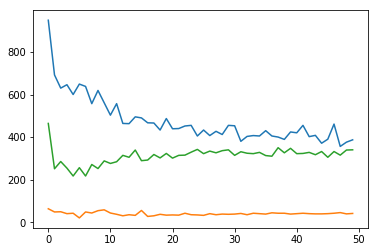

1


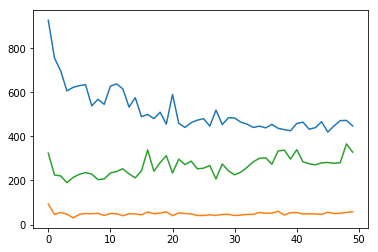

2


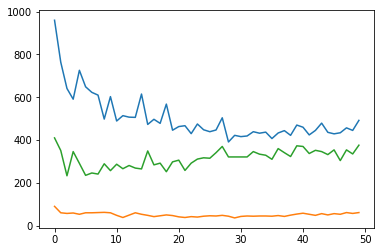

3


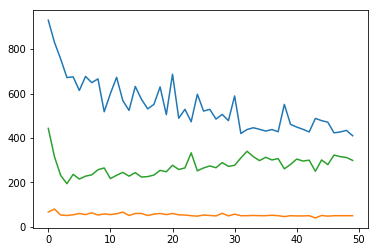

4


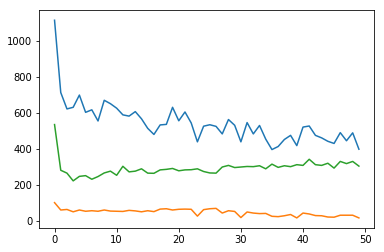

5


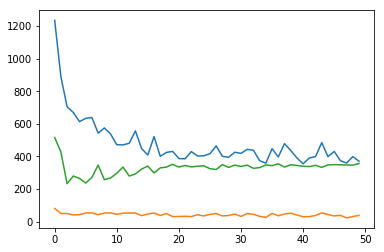

6


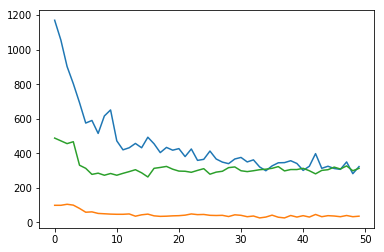

7


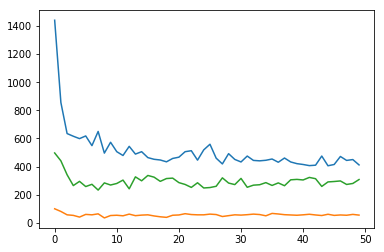

8


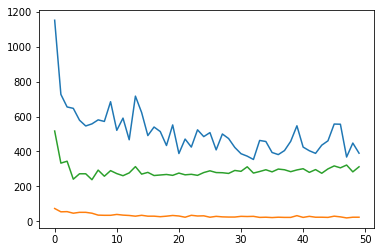

9


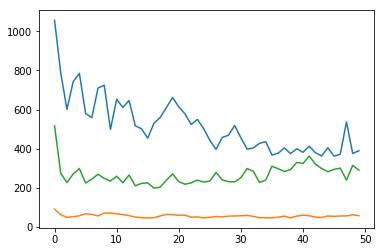

In [6]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


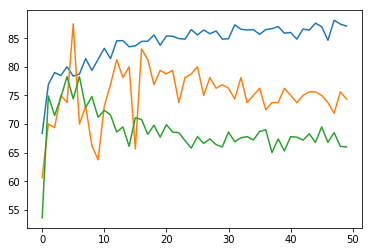

1


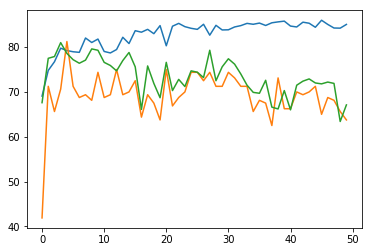

2


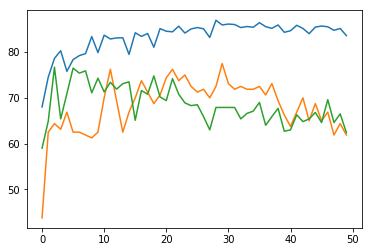

3


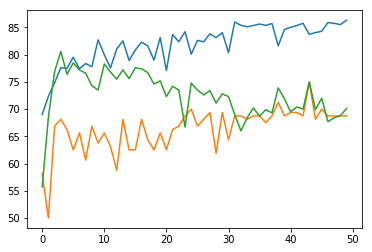

4


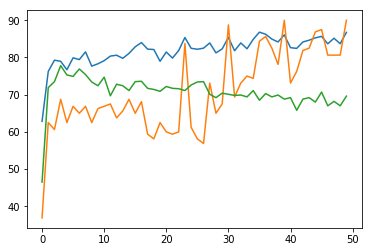

5


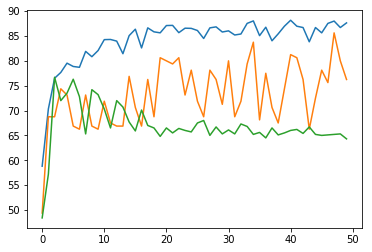

6


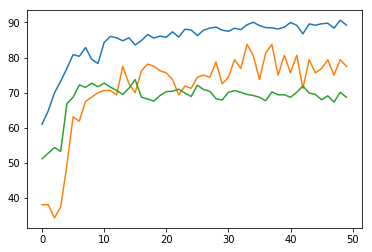

7


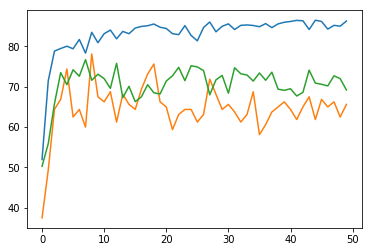

8


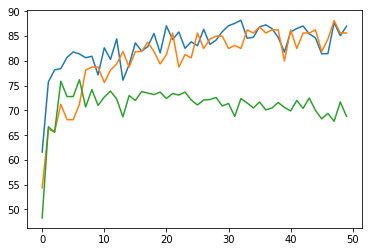

9


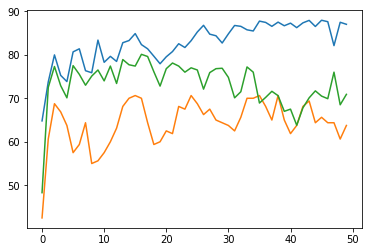

In [7]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

(50,)
Training accuracy 86.6%+-1.418562889099121
Validation accuracy 72.8%+-9.207673072814941
Testing accuracy 67.7%+-2.5878357887268066


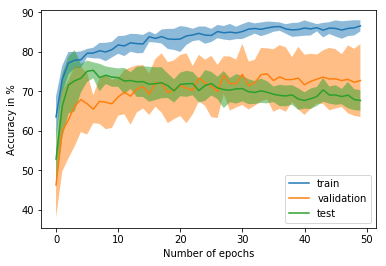

In [8]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(50))
print(stddev_train_errors.shape)

#plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
#plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
#plt.errorbar(epoch, mean_test_errors, stddev_test_errors)

plt.plot(epoch, mean_train_errors)
plt.plot(epoch, mean_val_errors)
plt.plot(epoch, mean_test_errors)
plt.fill_between(epoch, mean_train_errors+stddev_train_errors, mean_train_errors-stddev_train_errors, alpha=0.5)
plt.fill_between(epoch, mean_val_errors+stddev_val_errors, mean_val_errors-stddev_val_errors, alpha=0.5)
plt.fill_between(epoch, mean_test_errors+stddev_test_errors, mean_test_errors-stddev_test_errors, alpha=0.5)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])

print("Training accuracy {:4.3g}%+-{}".format(mean_train_errors[-1], stddev_train_errors[-1]))
print("Validation accuracy {:4.3g}%+-{}".format(mean_val_errors[-1], stddev_val_errors[-1]))
print("Testing accuracy {:4.3g}%+-{}".format(mean_test_errors[-1], stddev_test_errors[-1]))